In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-19 21:02:57.036358
thunder  Thu Dec 19 21:02:57 2019
[0] GeForce GTX 1080 Ti | 46'C,   8 % | 10895 / 11178 MB | patra(10885M)
[1] GeForce GTX 1080 Ti | 49'C,   0 % | 10895 / 11178 MB | patra(10885M)
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 27'C,   0 % | 10799 / 11178 MB | gerritsn(10789M)
[6] GeForce GTX 1080 Ti | 30'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Thu Dec 19 21:03:09 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 33%   45C    P2   131W / 250W |  10895MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 34%   48C    P2    56W / 250W |  10895Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "3"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:84]:
        layer.trainable = False
    for layer in mobile_conv.layers[84:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [17]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,051,649
Non-trainable params: 2,178,240
_________________________________________________________________


In [18]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=150
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [19]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/150
50/50 [==============================] - 24s 484ms/step - loss: 0.7626 - Accuracy: 0.5475 - Precision: 0.5893 - Recall: 0.4348 - F1: 0.4556 - AUC: 0.5740 - val_loss: 0.4356 - val_Accuracy: 0.8500 - val_Precision: 0.0250 - val_Recall: 0.0500 - val_F1: 0.0333 - val_AUC: 0.5509
Epoch 2/150
50/50 [==============================] - 22s 441ms/step - loss: 0.6797 - Accuracy: 0.5969 - Precision: 0.5875 - Recall: 0.6205 - F1: 0.5956 - AUC: 0.6430 - val_loss: 0.5978 - val_Accuracy: 0.6969 - val_Precision: 0.0125 - val_Recall: 0.0500 - val_F1: 0.0200 - val_AUC: 0.4475
Epoch 3/150
50/50 [==============================] - 23s 460ms/step - loss: 0.6534 - Accuracy: 0.6125 - Precision: 0.6066 - Recall: 0.6320 - F1: 0.6111 - AUC: 0.6737 - val_loss: 0.8044 - val_Accuracy: 0.5594 - val_Precision: 0.0548 - val_Recall: 0.4500 - val_F1: 0.0959 - val_AUC: 0.6811
Epoch 4/150
50/50 [==============================] - 24s 480ms/step - loss: 0.6556 - Accuracy: 0.6269 - Precision: 0.6156 - Recall: 0.63

Epoch 29/150
50/50 [==============================] - 23s 464ms/step - loss: 0.5932 - Accuracy: 0.6744 - Precision: 0.6743 - Recall: 0.6963 - F1: 0.6774 - AUC: 0.7439 - val_loss: 0.9824 - val_Accuracy: 0.2937 - val_Precision: 0.0374 - val_Recall: 0.6000 - val_F1: 0.0695 - val_AUC: 0.6970
Epoch 30/150
50/50 [==============================] - 24s 481ms/step - loss: 0.5725 - Accuracy: 0.7038 - Precision: 0.6817 - Recall: 0.7309 - F1: 0.6985 - AUC: 0.7732 - val_loss: 1.2122 - val_Accuracy: 0.2438 - val_Precision: 0.0195 - val_Recall: 0.4000 - val_F1: 0.0370 - val_AUC: 0.5483
Epoch 31/150
50/50 [==============================] - 23s 467ms/step - loss: 0.5888 - Accuracy: 0.6831 - Precision: 0.6898 - Recall: 0.6912 - F1: 0.6828 - AUC: 0.7503 - val_loss: 0.9770 - val_Accuracy: 0.2281 - val_Precision: 0.0195 - val_Recall: 0.5000 - val_F1: 0.0375 - val_AUC: 0.6590
Epoch 32/150
50/50 [==============================] - 24s 486ms/step - loss: 0.6040 - Accuracy: 0.6700 - Precision: 0.6666 - Recall: 

50/50 [==============================] - 23s 467ms/step - loss: 0.5870 - Accuracy: 0.6875 - Precision: 0.6910 - Recall: 0.7182 - F1: 0.6965 - AUC: 0.7534 - val_loss: 1.0691 - val_Accuracy: 0.3000 - val_Precision: 0.0244 - val_Recall: 0.4000 - val_F1: 0.0458 - val_AUC: 0.5162
Epoch 58/150
50/50 [==============================] - 24s 479ms/step - loss: 0.5929 - Accuracy: 0.6869 - Precision: 0.6758 - Recall: 0.7181 - F1: 0.6885 - AUC: 0.7446 - val_loss: 1.0082 - val_Accuracy: 0.2969 - val_Precision: 0.0574 - val_Recall: 0.7000 - val_F1: 0.1047 - val_AUC: 0.5983
Epoch 59/150
50/50 [==============================] - 23s 466ms/step - loss: 0.5669 - Accuracy: 0.7019 - Precision: 0.6878 - Recall: 0.7170 - F1: 0.6970 - AUC: 0.7756 - val_loss: 0.9653 - val_Accuracy: 0.2625 - val_Precision: 0.0214 - val_Recall: 0.4000 - val_F1: 0.0405 - val_AUC: 0.5308
Epoch 60/150
50/50 [==============================] - 23s 461ms/step - loss: 0.5786 - Accuracy: 0.6888 - Precision: 0.6886 - Recall: 0.7059 - F1: 

50/50 [==============================] - 23s 461ms/step - loss: 0.5891 - Accuracy: 0.6881 - Precision: 0.6902 - Recall: 0.7055 - F1: 0.6914 - AUC: 0.7511 - val_loss: 0.9958 - val_Accuracy: 0.2781 - val_Precision: 0.0287 - val_Recall: 0.4000 - val_F1: 0.0534 - val_AUC: 0.6417
Epoch 86/150
50/50 [==============================] - 24s 485ms/step - loss: 0.5738 - Accuracy: 0.7031 - Precision: 0.6790 - Recall: 0.7307 - F1: 0.6970 - AUC: 0.7710 - val_loss: 1.0956 - val_Accuracy: 0.2750 - val_Precision: 0.0160 - val_Recall: 0.2500 - val_F1: 0.0300 - val_AUC: 0.5255
Epoch 87/150
50/50 [==============================] - 23s 466ms/step - loss: 0.5896 - Accuracy: 0.6950 - Precision: 0.7026 - Recall: 0.7178 - F1: 0.7036 - AUC: 0.7539 - val_loss: 1.0961 - val_Accuracy: 0.2750 - val_Precision: 0.0217 - val_Recall: 0.4500 - val_F1: 0.0413 - val_AUC: 0.5758
Epoch 88/150
50/50 [==============================] - 23s 469ms/step - loss: 0.5769 - Accuracy: 0.6925 - Precision: 0.7103 - Recall: 0.7034 - F1: 

50/50 [==============================] - 22s 449ms/step - loss: 0.5742 - Accuracy: 0.6794 - Precision: 0.6701 - Recall: 0.6852 - F1: 0.6722 - AUC: 0.7666 - val_loss: 1.0045 - val_Accuracy: 0.2562 - val_Precision: 0.0450 - val_Recall: 0.5000 - val_F1: 0.0807 - val_AUC: 0.6496
Epoch 114/150
50/50 [==============================] - 22s 436ms/step - loss: 0.5889 - Accuracy: 0.6875 - Precision: 0.6773 - Recall: 0.7109 - F1: 0.6879 - AUC: 0.7516 - val_loss: 1.0570 - val_Accuracy: 0.2438 - val_Precision: 0.0160 - val_Recall: 0.3000 - val_F1: 0.0302 - val_AUC: 0.6578
Epoch 115/150
50/50 [==============================] - 22s 432ms/step - loss: 0.5659 - Accuracy: 0.7063 - Precision: 0.7220 - Recall: 0.7161 - F1: 0.7146 - AUC: 0.7759 - val_loss: 1.0030 - val_Accuracy: 0.2937 - val_Precision: 0.0249 - val_Recall: 0.4000 - val_F1: 0.0466 - val_AUC: 0.5342
Epoch 116/150
50/50 [==============================] - 22s 447ms/step - loss: 0.5680 - Accuracy: 0.7063 - Precision: 0.6847 - Recall: 0.7335 - F

50/50 [==============================] - 23s 463ms/step - loss: 0.5620 - Accuracy: 0.7069 - Precision: 0.6873 - Recall: 0.7339 - F1: 0.7038 - AUC: 0.7834 - val_loss: 1.0815 - val_Accuracy: 0.2531 - val_Precision: 0.0244 - val_Recall: 0.5000 - val_F1: 0.0462 - val_AUC: 0.7391
Epoch 142/150
50/50 [==============================] - 24s 477ms/step - loss: 0.5824 - Accuracy: 0.6925 - Precision: 0.7044 - Recall: 0.7092 - F1: 0.7012 - AUC: 0.7602 - val_loss: 0.9195 - val_Accuracy: 0.2656 - val_Precision: 0.0396 - val_Recall: 0.5500 - val_F1: 0.0725 - val_AUC: 0.4965
Epoch 143/150
50/50 [==============================] - 23s 462ms/step - loss: 0.5902 - Accuracy: 0.6881 - Precision: 0.6761 - Recall: 0.7150 - F1: 0.6865 - AUC: 0.7526 - val_loss: 1.0046 - val_Accuracy: 0.2375 - val_Precision: 0.0153 - val_Recall: 0.4000 - val_F1: 0.0294 - val_AUC: 0.5744
Epoch 144/150
50/50 [==============================] - 23s 453ms/step - loss: 0.5812 - Accuracy: 0.6915 - Precision: 0.6945 - Recall: 0.7074 - F

In [20]:
print("Time taken:",end-start)

Time taken: 3470.232802629471


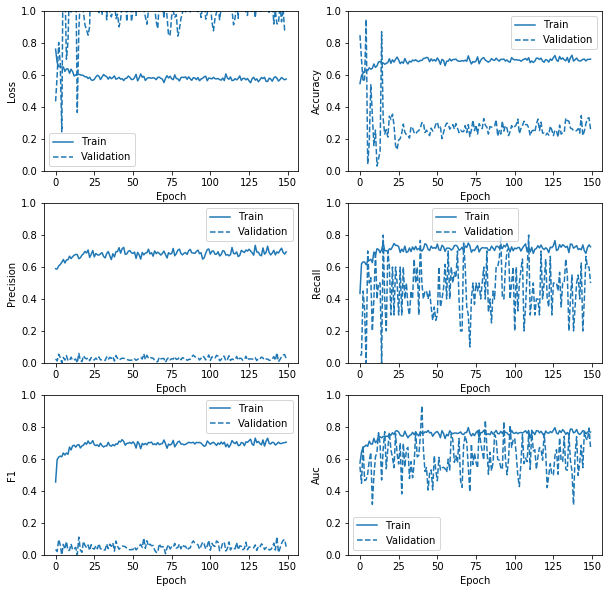

In [21]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/150
50/50 [==============================] - 21s 421ms/step - loss: 0.6939 - Accuracy: 0.5813 - Precision: 0.1682 - Recall: 0.7977 - F1: 0.2666 - AUC: 0.7758 - val_loss: 0.9315 - val_Accuracy: 0.2969 - val_Precision: 0.0171 - val_Recall: 0.2500 - val_F1: 0.0318 - val_AUC: 0.5775
Epoch 2/150
50/50 [==============================] - 21s 420ms/step - loss: 0.6590 - Accuracy: 0.6087 - Precision: 0.1684 - Recall: 0.7677 - F1: 0.2665 - AUC: 0.7798 - val_loss: 0.9632 - val_Accuracy: 0.2812 - val_Precision: 0.0333 - val_Recall: 0.5000 - val_F1: 0.0622 - val_AUC: 0.6052
Epoch 3/150
50/50 [==============================] - 22s 432ms/step - loss: 0.6481 - Accuracy: 0.6338 - Precision: 0.1460 - Recall: 0.6523 - F1: 0.2274 - AUC: 0.7720 - val_loss: 1.0456 - val_Accuracy: 0.2625 - val_Precision: 0.0383 - val_Recall: 0.5667 - val_F1: 0.0711 - val_AUC: 0.5874
Epoch 4/150
50/50 [==============================] - 21s 414ms/step - loss: 0.6082 - Accuracy: 0.6700 - Precision: 0.1886 - Recall: 0.69

50/50 [==============================] - 21s 414ms/step - loss: 0.3608 - Accuracy: 0.8838 - Precision: 0.2883 - Recall: 0.2977 - F1: 0.2588 - AUC: 0.7832 - val_loss: 0.7975 - val_Accuracy: 0.4500 - val_Precision: 0.0155 - val_Recall: 0.2000 - val_F1: 0.0286 - val_AUC: 0.4808
Epoch 30/150
50/50 [==============================] - 22s 432ms/step - loss: 0.3693 - Accuracy: 0.8756 - Precision: 0.3110 - Recall: 0.2833 - F1: 0.2618 - AUC: 0.7577 - val_loss: 0.6927 - val_Accuracy: 0.5250 - val_Precision: 0.0321 - val_Recall: 0.3000 - val_F1: 0.0573 - val_AUC: 0.7357
Epoch 31/150
50/50 [==============================] - 21s 414ms/step - loss: 0.3619 - Accuracy: 0.8850 - Precision: 0.3083 - Recall: 0.2328 - F1: 0.2458 - AUC: 0.7613 - val_loss: 0.7123 - val_Accuracy: 0.4906 - val_Precision: 0.0257 - val_Recall: 0.2500 - val_F1: 0.0465 - val_AUC: 0.5284
Epoch 32/150
50/50 [==============================] - 22s 450ms/step - loss: 0.3613 - Accuracy: 0.8838 - Precision: 0.3403 - Recall: 0.2450 - F1: 

50/50 [==============================] - 20s 406ms/step - loss: 0.2675 - Accuracy: 0.9237 - Precision: 0.2133 - Recall: 0.1347 - F1: 0.1545 - AUC: 0.8189 - val_loss: 0.5876 - val_Accuracy: 0.7156 - val_Precision: 0.0533 - val_Recall: 0.3000 - val_F1: 0.0897 - val_AUC: 0.6559
Epoch 58/150
50/50 [==============================] - 21s 410ms/step - loss: 0.2856 - Accuracy: 0.9150 - Precision: 0.1967 - Recall: 0.1033 - F1: 0.1237 - AUC: 0.7658 - val_loss: 0.6619 - val_Accuracy: 0.6906 - val_Precision: 0.0177 - val_Recall: 0.1500 - val_F1: 0.0310 - val_AUC: 0.6095
Epoch 59/150
50/50 [==============================] - 22s 431ms/step - loss: 0.3030 - Accuracy: 0.9013 - Precision: 0.1800 - Recall: 0.0575 - F1: 0.0842 - AUC: 0.7657 - val_loss: 0.4854 - val_Accuracy: 0.7125 - val_Precision: 0.0436 - val_Recall: 0.2500 - val_F1: 0.0708 - val_AUC: 0.5815
Epoch 60/150
50/50 [==============================] - 20s 392ms/step - loss: 0.2900 - Accuracy: 0.9106 - Precision: 0.2267 - Recall: 0.0877 - F1: 

50/50 [==============================] - 22s 432ms/step - loss: 0.2862 - Accuracy: 0.9000 - Precision: 0.0600 - Recall: 0.0200 - F1: 0.0290 - AUC: 0.7687 - val_loss: 0.5572 - val_Accuracy: 0.8219 - val_Precision: 0.0429 - val_Recall: 0.1000 - val_F1: 0.0600 - val_AUC: 0.5990
Epoch 86/150
50/50 [==============================] - 20s 401ms/step - loss: 0.2611 - Accuracy: 0.9212 - Precision: 0.1400 - Recall: 0.0519 - F1: 0.0690 - AUC: 0.7530 - val_loss: 0.4359 - val_Accuracy: 0.7969 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.6775
Epoch 87/150
50/50 [==============================] - 21s 415ms/step - loss: 0.2708 - Accuracy: 0.9106 - Precision: 0.0800 - Recall: 0.0307 - F1: 0.0433 - AUC: 0.7737 - val_loss: 0.4902 - val_Accuracy: 0.8219 - val_Precision: 0.0643 - val_Recall: 0.1833 - val_F1: 0.0944 - val_AUC: 0.6833
Epoch 88/150
50/50 [==============================] - 21s 429ms/step - loss: 0.2752 - Accuracy: 0.9056 - Precision: 0.0400 - Recall: 0.0133 - F1: 

50/50 [==============================] - 20s 400ms/step - loss: 0.2578 - Accuracy: 0.9181 - Precision: 0.0400 - Recall: 0.0150 - F1: 0.0213 - AUC: 0.7344 - val_loss: 0.4269 - val_Accuracy: 0.9031 - val_Precision: 0.0958 - val_Recall: 0.2333 - val_F1: 0.1222 - val_AUC: 0.6358
Epoch 114/150
50/50 [==============================] - 22s 435ms/step - loss: 0.2746 - Accuracy: 0.9044 - Precision: 0.0600 - Recall: 0.0192 - F1: 0.0278 - AUC: 0.7760 - val_loss: 0.3837 - val_Accuracy: 0.8687 - val_Precision: 0.0750 - val_Recall: 0.2500 - val_F1: 0.1086 - val_AUC: 0.5745
Epoch 115/150
50/50 [==============================] - 20s 393ms/step - loss: 0.2640 - Accuracy: 0.9119 - Precision: 0.0600 - Recall: 0.0250 - F1: 0.0347 - AUC: 0.7567 - val_loss: 0.4027 - val_Accuracy: 0.8719 - val_Precision: 0.0700 - val_Recall: 0.1000 - val_F1: 0.0786 - val_AUC: 0.7114
Epoch 116/150
50/50 [==============================] - 20s 398ms/step - loss: 0.2518 - Accuracy: 0.9119 - Precision: 0.0200 - Recall: 0.0067 - F

Epoch 141/150
50/50 [==============================] - 21s 412ms/step - loss: 0.2760 - Accuracy: 0.9050 - Precision: 0.0400 - Recall: 0.0117 - F1: 0.0180 - AUC: 0.7615 - val_loss: 0.3840 - val_Accuracy: 0.9031 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.7201
Epoch 142/150
50/50 [==============================] - 21s 416ms/step - loss: 0.2493 - Accuracy: 0.9200 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7459 - val_loss: 0.3877 - val_Accuracy: 0.9062 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5357
Epoch 143/150
50/50 [==============================] - 21s 430ms/step - loss: 0.2436 - Accuracy: 0.9169 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8068 - val_loss: 0.3228 - val_Accuracy: 0.9500 - val_Precision: 0.0333 - val_Recall: 0.0333 - val_F1: 0.0333 - val_AUC: 0.7855
Epoch 144/150
50/50 [==============================] - 20s 401ms/step - loss: 0.2864 - Accurac

In [23]:
print("Time taken:",end-start)

Time taken: 3080.1413962841034


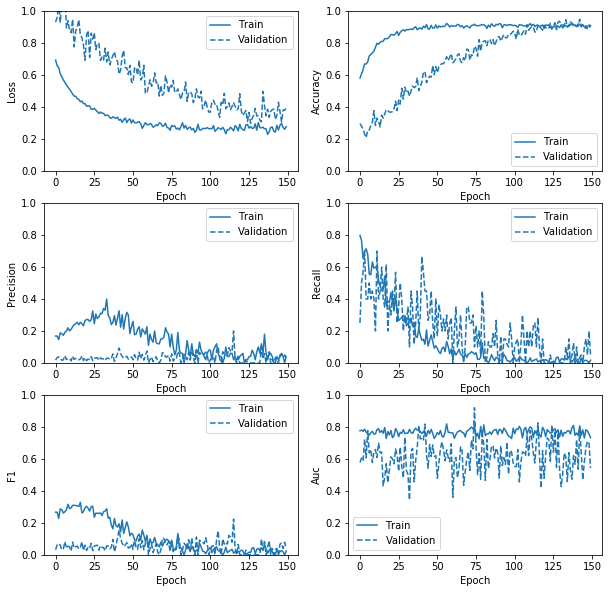

In [24]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [25]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/150
50/50 [==============================] - 21s 428ms/step - loss: 0.1675 - Accuracy: 0.9600 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7849 - val_loss: 0.2993 - val_Accuracy: 0.9406 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7555
Epoch 2/150
50/50 [==============================] - 21s 427ms/step - loss: 0.1720 - Accuracy: 0.9588 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7778 - val_loss: 0.3875 - val_Accuracy: 0.9000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6002
Epoch 3/150
50/50 [==============================] - 20s 403ms/step - loss: 0.1784 - Accuracy: 0.9556 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7699 - val_loss: 0.3600 - val_Accuracy: 0.9469 - val_Precision: 0.1000 - val_Recall: 0.2000 - val_F1: 0.1333 - val_AUC: 0.7561
Epoch 4/150
50/50 [==============================] - 21s 428ms/step - loss: 0.1938 - Acc

50/50 [==============================] - 21s 418ms/step - loss: 0.1557 - Accuracy: 0.9625 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7334 - val_loss: 0.3475 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6716
Epoch 29/150
50/50 [==============================] - 20s 393ms/step - loss: 0.1864 - Accuracy: 0.9475 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7557 - val_loss: 0.3186 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4589
Epoch 30/150
50/50 [==============================] - 20s 406ms/step - loss: 0.1758 - Accuracy: 0.9488 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7936 - val_loss: 0.2681 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6737
Epoch 31/150
50/50 [==============================] - 21s 416ms/step - loss: 0.1940 - 

50/50 [==============================] - 21s 428ms/step - loss: 0.1564 - Accuracy: 0.9563 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8090 - val_loss: 0.3543 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6153
Epoch 55/150
50/50 [==============================] - 20s 401ms/step - loss: 0.1805 - Accuracy: 0.9463 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7912 - val_loss: 0.3765 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5625
Epoch 56/150
50/50 [==============================] - 20s 390ms/step - loss: 0.1720 - Accuracy: 0.9494 - Precision: 0.0200 - Recall: 0.0200 - F1: 0.0200 - AUC: 0.7946 - val_loss: 0.2572 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6912
Epoch 57/150
50/50 [==============================] - 22s 436ms/step - loss: 0.1749 - 

50/50 [==============================] - 20s 394ms/step - loss: 0.1634 - Accuracy: 0.9544 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7758 - val_loss: 0.2674 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5274
Epoch 81/150
50/50 [==============================] - 21s 411ms/step - loss: 0.1543 - Accuracy: 0.9556 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8153 - val_loss: 0.2624 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7618
Epoch 82/150
50/50 [==============================] - 21s 411ms/step - loss: 0.1921 - Accuracy: 0.9419 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7730 - val_loss: 0.3101 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5020
Epoch 83/150
50/50 [==============================] - 20s 394ms/step - los

50/50 [==============================] - 20s 405ms/step - loss: 0.1857 - Accuracy: 0.9450 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7729 - val_loss: 0.2085 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8086
Epoch 107/150
50/50 [==============================] - 22s 444ms/step - loss: 0.1724 - Accuracy: 0.9500 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.7822 - val_loss: 0.2003 - val_Accuracy: 0.9871 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7353
Epoch 108/150
50/50 [==============================] - 19s 379ms/step - loss: 0.1628 - Accuracy: 0.9563 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.7665 - val_loss: 0.2676 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6070
Epoch 109/150
50/50 [==============================] - 20s 403ms/step - loss: 0.1501 - Accuracy:

50/50 [==============================] - 21s 420ms/step - loss: 0.1881 - Accuracy: 0.9463 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7544 - val_loss: 0.2074 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5540
Epoch 133/150
50/50 [==============================] - 20s 404ms/step - loss: 0.1895 - Accuracy: 0.9444 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7688 - val_loss: 0.2400 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5452
Epoch 134/150
50/50 [==============================] - 19s 384ms/step - loss: 0.1634 - Accuracy: 0.9538 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7778 - val_loss: 0.2679 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5903
Epoch 135/150
50/50 [==============================] - 19s 376ms/step - 

In [26]:
print("Time taken:",end-start)

Time taken: 2999.5590131282806


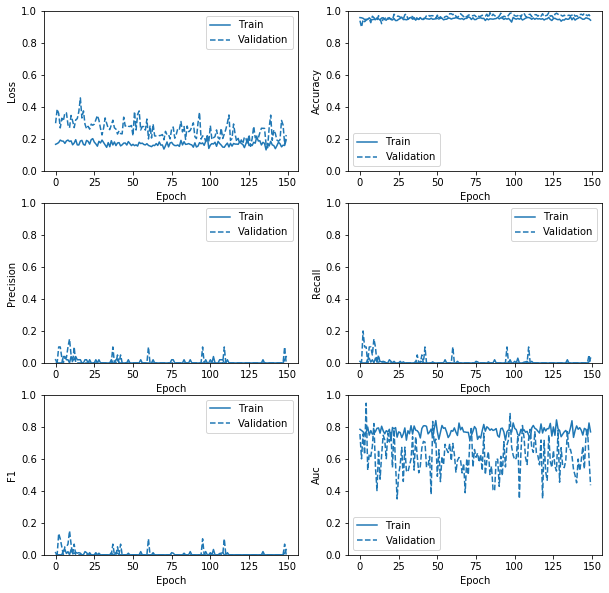

In [27]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [28]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [31]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = class_weight,
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [32]:
# print("Time taken:",end-start)

In [33]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [34]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 21s 213ms/step


In [35]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.219 :   0.266
Accuracy : 0.971 :   0.975
Precision : 0.000 :   0.010
Recall : 0.000 :   0.010
F1 : 0.000 :   0.010
AUC : 0.593 :   0.662


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [36]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(746.7823812961578, 135.12496304512024)

In [37]:
np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [38]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [39]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

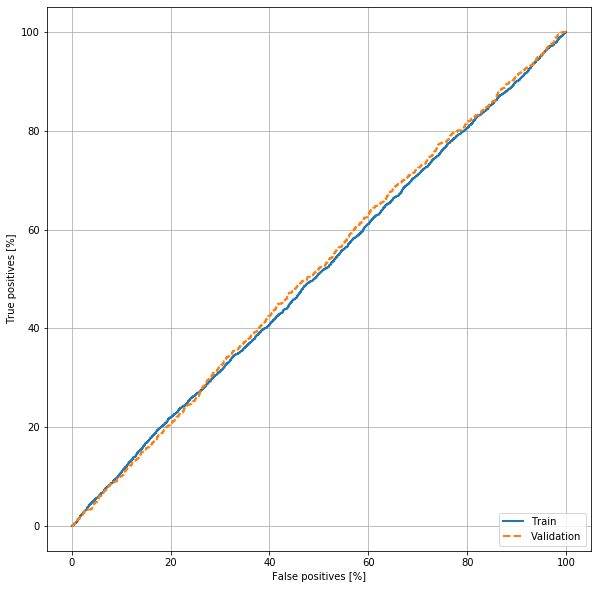

In [40]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 99214 
FP: 241 
FN: 2375 
TP: 4
Healthy Patients - correctly identified (True Negatives):  99214 0.9975767935247096
Healthy Patients - predicted to have glaucoma (False Positives):  241 0.0024232064752903325
Glaucoma Patients - predicted healthy (False Negatives):  2375 0.9983186212694409
Glaucoma Patients - correctly identified (True Positives):  4 0.0016813787305590584

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


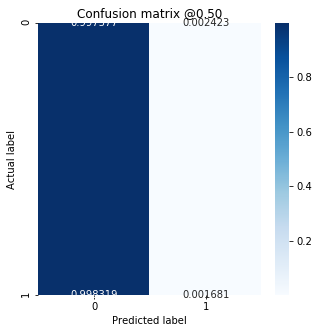

In [41]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33052 
FP: 82 
FN: 807 
TP: 2
Healthy Patients - correctly identified (True Negatives):  33052 0.9975252007001871
Healthy Patients - predicted to have glaucoma (False Positives):  82 0.002474799299812881
Glaucoma Patients - predicted healthy (False Negatives):  807 0.9975278121137207
Glaucoma Patients - correctly identified (True Positives):  2 0.002472187886279357

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


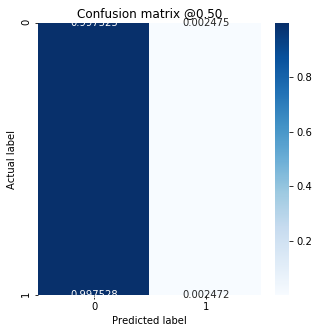

In [42]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [49]:
# history = up3_history
# tag_value = "trained twice bal and 1:10 and 1:20 with 84 tr layers and no cw"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [50]:
# client = MlflowClient()
# run = client.create_run('18')
# client.set_tag(run.info.run_id, "tag_key", tag_value)